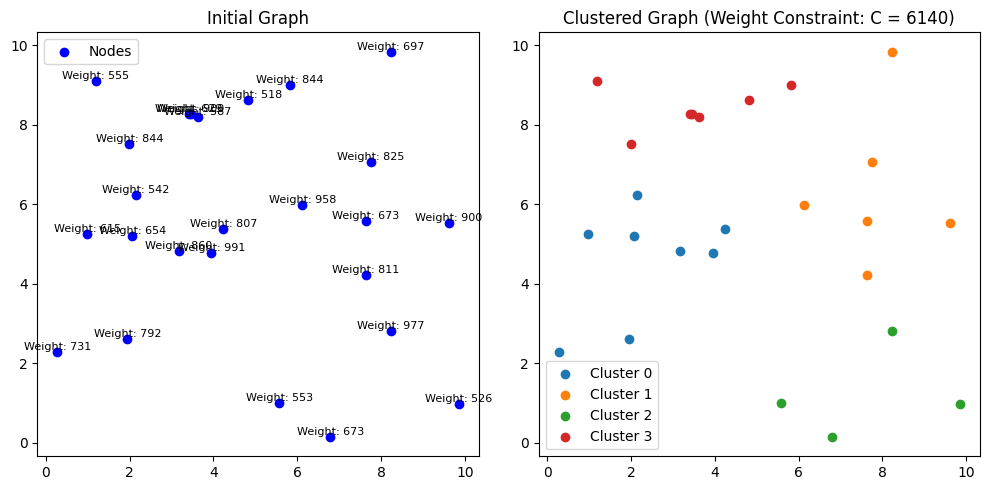

Points of the smallest cluster:
[[8.23604701 2.81372832]
 [6.78715342 0.14782989]
 [9.85181107 0.98332726]
 [5.57570877 1.01222825]]
Latitude array: [47.44070113 47.3340652  47.36748509 47.36864113]
Longitude array: [8.88819388 8.83023814 8.95282444 8.78178035]


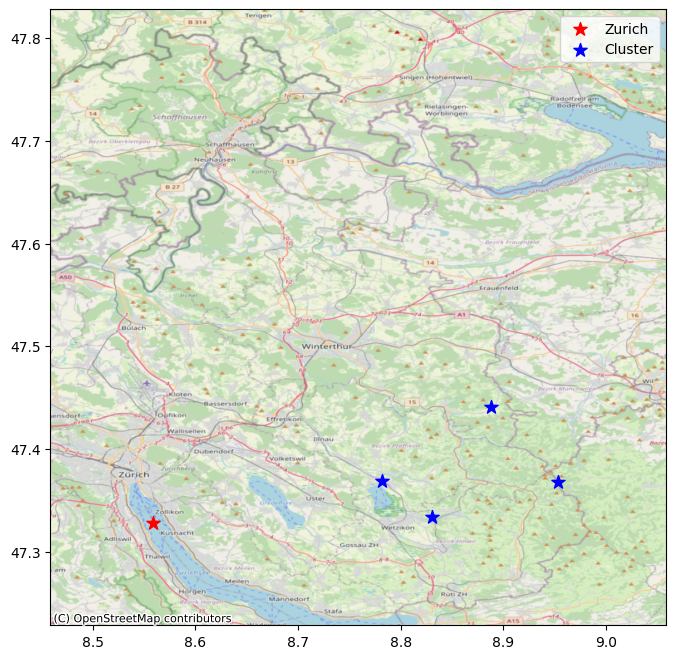

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import geopandas as gpd
import contextily as ctx

def coordinate_to_latlon(x, y):
    latZurigo = 47.328152
    lonZurigo = 8.558752
    lat = np.array(latZurigo + 0.4 * (np.array(y) / 10))
    lon = np.array(lonZurigo + 0.4 * (np.array(x) / 10))
    return lat, lon


def create_clusters(nodes, weights, distances, C):
    # Set the number of clusters to ensure the weight constraint is met
    k = int(np.ceil(np.sum(weights) / C))
    if k == 0:
        k = 1
    
    # Initialize k-means model with a fixed number of clusters
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)

    # Fit the model to the data
    kmeans.fit(nodes)

    # Get the cluster labels
    labels = kmeans.labels_

    # Adjust clusters to satisfy weight constraint
    cluster_weights = np.zeros(k)
    for i, label in enumerate(labels):
        cluster_weights[label] += weights[i]

    exceeded_clusters = np.where(cluster_weights > C)[0]
    for cluster_id in exceeded_clusters:
        # Find the points belonging to the exceeded cluster
        cluster_indices = np.where(labels == cluster_id)[0]
        if len(cluster_indices) == 0:
            continue
        # Calculate the distances between each point in the cluster
        cluster_distances = distances[cluster_indices][:, cluster_indices]
        # Find the index of the point furthest from the centroid
        furthest_point_index = cluster_indices[np.argmax(cluster_distances)]
        # Find the feasible clusters for reassignment
        feasible_clusters = np.where(cluster_weights + weights[furthest_point_index] <= C)[0]
        if len(feasible_clusters) > 0:
            # Sort feasible clusters by weight
            sorted_feasible_clusters = feasible_clusters[np.argsort(cluster_weights[feasible_clusters])]
            # Reassign the furthest point to the feasible cluster with the minimum weight
            new_cluster_id = sorted_feasible_clusters[0]
            # Reassign the furthest point to the new cluster
            labels[furthest_point_index] = new_cluster_id
            # Update the cluster weights
            cluster_weights[cluster_id] -= weights[furthest_point_index]
            cluster_weights[new_cluster_id] += weights[furthest_point_index]

    return labels, k

def smallest_cluster_points(cluster_points):
    """
    Find the smallest cluster among the given cluster points and return its points.
    
    Parameters:
    cluster_points (list of arrays): List containing arrays of points for each cluster.
    
    Returns:
    np.array: Points of the smallest cluster.
    """
    # Get the number of points in each cluster
    cluster_sizes = [len(points) for points in cluster_points]
    
    # Find the index of the smallest cluster
    smallest_cluster_index = np.argmin(cluster_sizes)
    
    # Return the points of the smallest cluster
    return cluster_points[smallest_cluster_index]

# Visualizing the initial graph and clusters
def visualize_graph(nodes, clusters, C, weights):
    plt.figure(figsize=(10, 5))
    
    # Plot initial graph
    plt.subplot(121)
    plt.scatter(nodes[:, 0], nodes[:, 1], c='blue', label='Nodes')
    for i, (x, y) in enumerate(nodes):
        plt.text(x, y, f'Weight: {weights[i]}', fontsize=8, ha='center', va='bottom')
    plt.title('Initial Graph')
    plt.legend()

    # Plot clustered graph
    plt.subplot(122)
    for cluster_id in range(len(np.unique(clusters))):
        cluster_points = nodes[clusters == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}')
    plt.title('Clustered Graph (Weight Constraint: C = {})'.format(C))
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
num_nodes = 25
nodes = np.random.rand(num_nodes, 2) * 10  # Random nodes
weights = np.random.randint(500, 1000 , num_nodes)  # Random weights for each node
# Modify distances to represent the distances between nodes composing the cluster
distances = np.array([[np.linalg.norm(nodes[i] - nodes[j]) for j in range(num_nodes)] for i in range(num_nodes)])
# Adjust the weight constraint based on the total weight of the nodes
C = 6140 

clusters, k = create_clusters(nodes, weights, distances, C)
visualize_graph(nodes, clusters, C, weights)

# Get the points of the smallest cluster
cluster_points = [nodes[clusters == cluster_id] for cluster_id in range(k)]
smallest_cluster = smallest_cluster_points(cluster_points)

# Print the points of the smallest cluster
print("Points of the smallest cluster:")
print(smallest_cluster)



# Assuming x, y are the coordinates of the smallest cluster
x = [coordinate[0] for coordinate in smallest_cluster]
y = [coordinate[1] for coordinate in smallest_cluster]
latitude, longitude = coordinate_to_latlon(x, y)
latZurigo = 47.328152
lonZurigo = 8.558752
# Create a GeoDataFrame for Zurich
zurich = gpd.GeoDataFrame(geometry=gpd.points_from_xy([lonZurigo], [latZurigo]))
# Create a GeoDataFrame for the smallest cluster
cluster = gpd.GeoDataFrame(geometry=gpd.points_from_xy(longitude, latitude))
# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
# Plot Zurich
zurich.plot(ax=ax, color='red', marker='*', markersize=100, label='Zurich')
# Plot the smallest cluster
cluster.plot(ax=ax, color='blue', marker='*', markersize=100, label='Cluster')
# Set the geographical limits
ax.set_xlim(lonZurigo - 0.1, lonZurigo + 0.5)
ax.set_ylim(latZurigo - 0.1, latZurigo + 0.5)
# Add topographic basemap
ctx.add_basemap(ax=ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
plt.legend()
plt.show()


print("Latitude array:", latitude)
print("Longitude array:", longitude)
